In [1]:
import numpy as np
# import minpy.numpy as np
import cv2
import math
import os
import os
canoe = os.listdir('canoe\input')
highway = os.listdir('highway\input')
skating = os.listdir('skating\input')

canoeT = os.listdir('canoe\groundtruth')
highwayT = os.listdir('highway\groundtruth')
skatingT = os.listdir('skating\groundtruth')
def get_gray(image):
    imageG = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return imageG

In [2]:
def inital_Ek(imageA, imageB, sigma_s ):   # get ek with T = infinity
    phi_seq = np.power( (imageA-imageB) , 2 )
    threshold = 2 * (sigma_s ** 2) * math.log(5 , math.e)
    i = np.where( phi_seq > threshold , 1 , 0 )
    i = i.astype(np.float32)
    return i

In [3]:
def First_order_Ek(imageA, imageB, ek, sigma_s , T):   # get ek with first-order MRF
    phi_seq = np.power( (imageA-imageB) , 2 )
    m,n = imageA.shape
    output = np.zeros((m,n))
    Diff = np.zeros((m,n))
    threshold_init = 2 * (sigma_s ** 2) * ( math.log(5 , math.e) )

    fil = np.array([[0, 1, 0],                        
                    [1, 0, 1],
                    [0, 1, 0]])

    Diff = cv2.filter2D(ek,-1,fil) 
                    
    threshold = threshold_init + 2 * (sigma_s ** 2) * (Diff/T)
    output = np.where( phi_seq > threshold , 1 , 0 )
    output = output.astype(np.float32)
    return output

In [4]:
def Second_order_Ek(imageA, imageB, ek, sigma_s , T):
    phi_seq = np.power( (imageA-imageB) , 2 )
    m,n = imageA.shape
    output = np.zeros((m,n))
    Diff = np.zeros((m,n))
    threshold_init = 2 * (sigma_s ** 2) * ( math.log(5 , math.e) )

    fil = np.array([[1, 1, 1],                        
                    [1, 0, 1],
                    [1, 1, 1]])

    Diff = cv2.filter2D(ek,-1,fil) 
                    
    threshold = threshold_init + 2 * (sigma_s ** 2) * (Diff/T)
    output = np.where( phi_seq > threshold , 1 , 0 )
    output = output.astype(np.float32)
    return output

In [5]:
def Second(imageA, imageB, ek, sigma_s  , T ):   # get ek with second-order MRF
    phi_seq = np.power( (imageA-imageB) , 2 )
    m,n = imageA.shape

    output = np.zeros((m,n))
    for i in range(1, m-1):
        for j in range(1, n-1):
            Qm = ek[i-1 ,j] + ek[i ,j-1] + ek[i ,j+1] + ek[i+1 ,j]  + ek[i-1 ,j-1] + ek[i-1 ,j+1] + ek[i+1 ,j-1] + ek[i+1 ,j+1]
            Diff = 8- 2*Qm
            threshold = 2 * (sigma_s ** 2) * ( math.log(5 , math.e) + (Diff/T) )
            if(phi_seq[i,j] > threshold):
                output[i,j] = 1

    output = output.astype(np.float32)
    return output

In [6]:
def Mar_iteration(sequence, Fixed_ek, type_function, sigma_s , T):
    if(sequence=="canoe"):     imgs=canoe
    elif(sequence=="highway"): imgs=highway
    elif(sequence=="skating"): imgs=skating
    output = []
    for k in range(len(imgs)-1):
        imageA = cv2.imread(sequence + "\\input\\" + imgs[k])
        imageB = cv2.imread(sequence + "\\input\\" + imgs[k+1])
        imageA = get_gray(imageA)
        imageB = get_gray(imageB)
        temp = Fixed_ek
        for i in range(3):
            if( type_function =="Fixed" ):
                ek = inital_Ek(imageA, imageB, sigma_s)
            elif( type_function =="First" ):
                ek = First_order_Ek(imageA, imageB, Fixed_ek[k], sigma_s , T)
                if(np.power( (temp-ek) , 2 ).sum()<10):
                    break
                else: temp = ek
            elif( type_function =="Second" ):
                ek = Second_order_Ek(imageA, imageB, Fixed_ek[k], sigma_s , T)
                if(np.power( (temp-ek) , 2 ).sum() < 50):
                    break
                else: temp = ek
        output.append(ek)
    return output

In [7]:
def one_seq(name,  sigma_s , T):
    fixed  = Mar_iteration(name, 0    , "Fixed" ,sigma_s , T)
    first  = Mar_iteration(name, fixed, "First" ,sigma_s , T)
    second = Mar_iteration(name, fixed, "Second" ,sigma_s , T)
    return fixed , first , second

In [ ]:
#canoe
sigma_s=5
T = 1
fixed_canoe, First_canoe, Second_canoe = one_seq( "canoe", sigma_s, T)

fixed_canoe_fifth, First_canoe_fifth, Second_canoe_fifth = one_seq( "canoe", sigma_s*0.2, T)
fixed_canoe_half, First_canoe_half, Second_canoe_half = one_seq( "canoe", sigma_s*0.5, T)
fixed_canoe_doub, First_canoe_doub, Second_canoe_doub = one_seq( "canoe", sigma_s*2, T)
fixed_canoe_five, First_canoe_five, Second_canoe_five = one_seq( "canoe", sigma_s*5, T)


In [ ]:
#highway
sigma_s=5
T = 1
fixed_highway, First_highway ,Second_highway= one_seq( "highway", sigma_s, T)

fixed_highway_fifth, First_highway_fifth ,Second_highway_fifth= one_seq( "highway", sigma_s*0.2, T)
fixed_highway_half, First_highway_half ,Second_highway_half= one_seq( "highway", sigma_s*0.5, T)
fixed_highway_doub, First_highway_doub ,Second_highway_doub= one_seq( "highway", sigma_s*2, T)
fixed_highway_five, First_highway_five ,Second_highway_five= one_seq( "highway", sigma_s*5, T)


In [ ]:
#skating
sigma_s=5
T = 0.7
fixed_skating, First_skating ,Second_skating = one_seq( "skating", sigma_s, T)

fixed_skating_fifth, First_skating_fifth ,Second_skating_fifth = one_seq( "skating", sigma_s*0.2, T)
fixed_skating_half, First_skating_half ,Second_skating_half = one_seq( "skating", sigma_s*0.5, T)
fixed_skating_doub, First_skating_doub ,Second_skating_doub = one_seq( "skating", sigma_s*2, T)
fixed_skating_five, First_skating_five ,Second_skating_five = one_seq( "skating", sigma_s*5, T)

In [ ]:
C=[fixed_canoe, First_canoe, Second_canoe,
  fixed_canoe_fifth, First_canoe_fifth, Second_canoe_fifth,
  fixed_canoe_half, First_canoe_half, Second_canoe_half,
  fixed_canoe_doub, First_canoe_doub, Second_canoe_doub,
  fixed_canoe_five, First_canoe_five, Second_canoe_five]

H=[fixed_highway, First_highway ,Second_highway,
fixed_highway_fifth, First_highway_fifth ,Second_highway_fifth,
fixed_highway_half, First_highway_half ,Second_highway_half,
fixed_highway_doub, First_highway_doub ,Second_highway_doub,
fixed_highway_five, First_highway_five ,Second_highway_five]

S=[fixed_skating, First_skating ,Second_skating,
fixed_skating_fifth, First_skating_fifth ,Second_skating_fifth,
fixed_skating_half, First_skating_half ,Second_skating_half,
fixed_skating_doub, First_skating_doub ,Second_skating_doub,
fixed_skating_five, First_skating_five ,Second_skating_five]

In [8]:
def calculate_roc(imageB, imageA):
    flat_imageA = imageA.ravel()
    flat_imageB = imageB.ravel()
    TP = np.sum((flat_imageA == 1) & (flat_imageB == 1))
    FP = np.sum((flat_imageA == 1) & (flat_imageB == 0))
    TN = np.sum((flat_imageA == 0) & (flat_imageB == 0))
    FN = np.sum((flat_imageA == 0) & (flat_imageB == 1))
    ROC= (TP+FN)/(TP+FP)
    return ROC

In [9]:
def ROC_one(sequence, imageA): #"canoe"
    if(sequence=="canoe"):     imgT=canoeT
    elif(sequence=="highway"): imgT=highwayT
    elif(sequence=="skating"): imgT=skatingT
    output = 0
    for k in range(imageA.shape[0] - 1):
        imageB = cv2.imread(sequence + "\\groundtruth\\" + imgT[k])
        imageB = get_gray(imageB)
        B = np.where( imageB > 100 , 1 , 0 )
        output += calculate_roc(imageA[k], B)
    output=output/(len(imageA)-1)
    return output

In [10]:
def ROC_s(sequence, imgs):
    output=np.arange(15)
    for i in range(15):
        output[i]=ROC_one(sequence, imgs[i])
    return output

In [2]:
# C = np.load('C.npy')
# H = np.load('H.npy')
S = np.load('S.npy')

In [ ]:
y_C = ROC_s("canoe",C)
y_H = ROC_s("highway",H)
y_S = ROC_s("skating",S)

In [11]:
import matplotlib.pyplot as plt
def plot_ROC(s, y_C):
    x_values = [s * i for i in [0.2, 0.5, 1, 2, 5]]

    y1=[y_C[0],y_C[3],y_C[6],y_C[9],y_C[12]]
    y2=[y_C[1],y_C[4],y_C[7],y_C[10],y_C[13]]
    y3=[y_C[2],y_C[5],y_C[8],y_C[11],y_C[14]]
    plt.plot(x_values, y1, label="fixed", marker='o')
    plt.plot(x_values, y2, label="First", marker='o')
    plt.plot(x_values, y3, label="Second", marker='o')
    
    plt.xlabel("sigma_s")
    plt.ylabel("precision/recall")
    plt.title("canoe")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
s=5
plot_ROC(s,y_C)

In [12]:
def plotf(original,detecs):
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title("Color Image")
    plt.axis('off')
    for i, bw_image in enumerate(detecs, start=2):
        plt.subplot(2, 3, i)
        plt.imshow(bw_image.squeeze(), cmap='gray')  # 使用squeeze()去掉单一的颜色通道
        plt.title(f"BW Image {i-1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

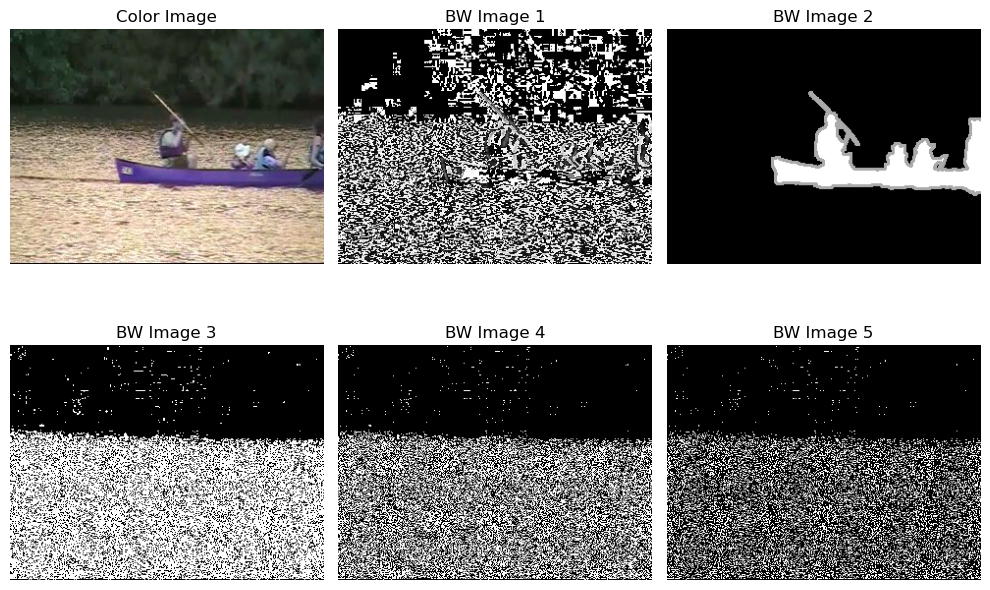

In [214]:
original = cv2.imread('canoe\input\in001000.jpg')
original2= cv2.imread('canoe\input\in000999.jpg')
detecs = []
detecs.append( np.absolute( get_gray(original) - get_gray(original2))  )
detecs.append( cv2.imread('canoe\groundtruth\gt001000.png') )
detecs.append( C[0,200] )
detecs.append( C[1,200] )
detecs.append( C[2,200] )
plotf(original,detecs)

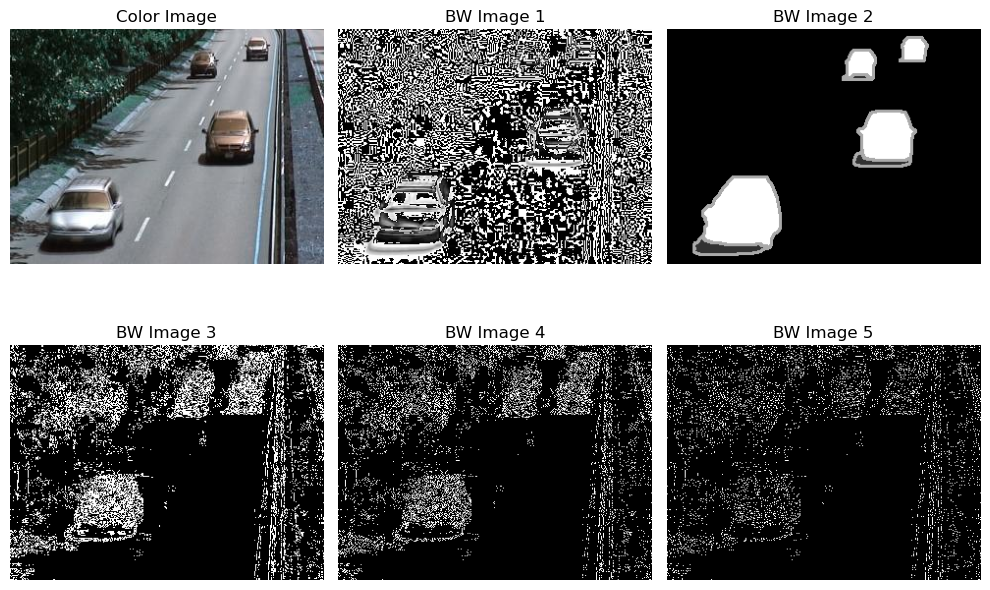

In [215]:
original = cv2.imread('highway\input\in001100.jpg')
original2= cv2.imread('highway\input\in001099.jpg')
detecs = []
detecs.append( np.absolute( get_gray(original) - get_gray(original2))  )
detecs.append( cv2.imread('highway\groundtruth\gt001100.png') )
detecs.append( H[0,100] )
detecs.append( H[1,100] )
detecs.append( H[2,100] )
plotf(original,detecs)

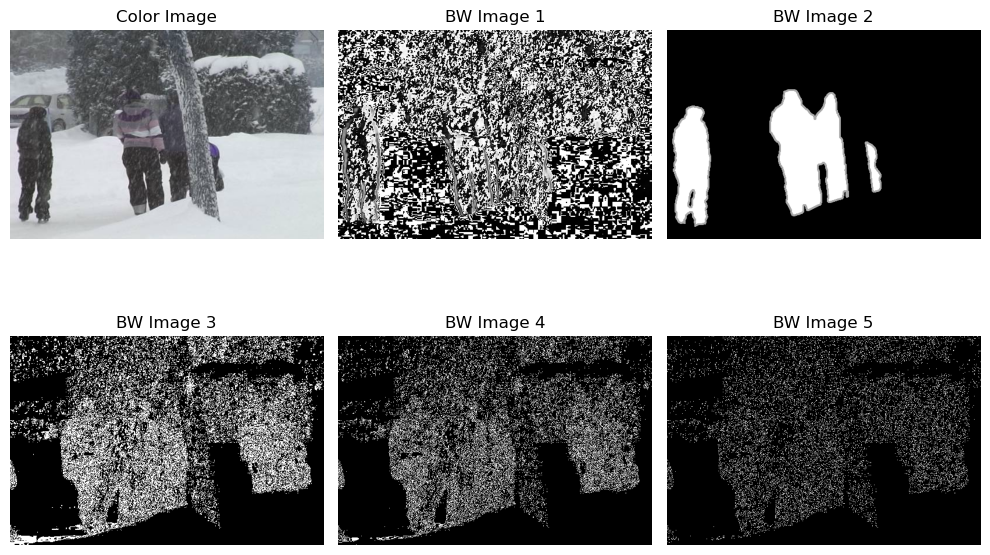

In [216]:
original = cv2.imread('skating\input\in001400.jpg')
original2= cv2.imread('skating\input\in001399.jpg')
detecs = []
detecs.append( np.absolute( get_gray(original) - get_gray(original2))  )
detecs.append( cv2.imread('skating\groundtruth\gt001400.png') )
detecs.append( S[0,50] )
detecs.append( S[1,50] )
detecs.append( S[2,50] )
plotf(original,detecs)

In [3]:
def concat_imgs(img1, img2, img3, img4):
    img1 = get_gray(img1)
    
    d = np.append(img1,img2,axis=1)
    e = np.append(img3,img4,axis=1)
    f = np.append(d,e,axis=0)

    return f

In [4]:
def outV(sequence , times): 
    if(sequence=="canoe"):     
        imgT = canoeT
        img  = C
    elif(sequence=="highway"): 
        imgT=highwayT
        img  = H
    elif(sequence=="skating"): 
        imgT=skatingT
        img  = S
    img = (img*255)
    img2 = img[0 + times]
    img3 = img[1+times]
    img4 = img[2+times]
    output = np.zeros(( 300, 720,1080   ))

    for k in range(len(imgT) - 1):
        i1 = cv2.imread(sequence + "\\groundtruth\\" + imgT[k])
        i2 = img2[k]
        i3 = img3[k]
        i4 = img4[k]
        fourIMG = concat_imgs(i1, i2, i3, i4)
        
        
        output[k] = fourIMG
    
    return output

In [5]:
def images_to_video(imgs, output_video_path, fps=30):
    
    height, width = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    for i in imgs:
        imgs = np.clip(i, 0, 255).astype(np.uint8)
        i  = cv2.cvtColor(imgs, cv2.COLOR_GRAY2BGR)
        out.write(i)

    out.release()

In [89]:
canoeV1 = outV("canoe" , 1)
canoeV2 = outV("canoe" , 2)
canoeV3 = outV("canoe" , 0)
canoeV4 = outV("canoe" , 3)
canoeV5 = outV("canoe" , 4)

a = np.append(canoeV1,canoeV2,axis=0)
a = np.append(a,canoeV3,axis=0)
a = np.append(a,canoeV4,axis=0)
# a = np.append(a,canoeV5,axis=0)
images_to_video(np.append(a,canoeV5,axis=0), "canoe.mp4", fps=30)

In [9]:
highwayV1 = outV("highway" , 1)
highwayV2 = outV("highway" , 2)
highwayV3 = outV("highway" , 0)
highwayV4 = outV("highway" , 3)
highwayV5 = outV("highway" , 4)


a = np.append(highwayV1,highwayV2,axis=0)
a = np.append(a,highwayV3,axis=0)
a = np.append(a,highwayV4,axis=0)
# a = np.append(a,highwayV5,axis=0)
images_to_video(np.append(a,highwayV5,axis=0), "highway.mp4", fps=30)

In [6]:
# skatingV1 = outV("skating" , 1)
# skatingV2 = outV("skating" , 2)
# skatingV3 = outV("skating" , 0)
# skatingV4 = outV("skating" , 3)
skatingV5 = outV("skating" , 4)


a = np.append(outV("skating" , 1) , outV("skating" , 2),axis=0)
a = np.append(a,outV("skating" , 0) ,axis=0)
a = np.append(a,outV("skating" , 4) ,axis=0)
images_to_video(np.append(a,outV("skating" , 4),axis=0), "skating.mp4", fps=30)